In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data 

In [ ]:
data_train_path = 'skin-lesions/train/'
data_valid_path = 'skin-lesions/valid/'
data_test_path = 'skin-lesions/test/'

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(data_train_path, transform = train_transform)
valid_dataset = ImageFolder(data_valid_path, transform = test_transform)
test_dataset = ImageFolder(data_test_path, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

In [ ]:
train_dataset.class_to_idx

{'melanoma': 0, 'not_melanoma': 1}

In [ ]:
def train(model, epochs, criterion, min_loss, optimizer, vectorize=False):
    training_losses, valid_losses, accs = [],[],[]
    for epoch in range(epochs):
        training_loss = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            if vectorize:
                images = images.reshape(-1, 224 * 224)

            optimizer.zero_grad()
            ps = model(images)
            loss = criterion(ps, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
        print(f"\tEPOCH: {epoch + 1}.. TRAINING LOSS: {training_loss}")

        training_losses.append(training_loss)
        model.eval()
        valid_loss = 0
        acc = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                if vectorize:
                    images = images.reshape(-1, 224 * 224 * 3)
                
                optimizer.zero_grad()
                ps = model(images)
                loss = criterion(ps, labels)
                
                valid_loss += loss.item()
                
                _, top_class = ps.topk(1, dim = 1)
                eq = top_class == labels.view(-1, 1)
                acc += eq.sum().item()
                
        valid_losses.append(valid_loss)
        accs.append(acc)
        acc = (acc/len(valid_dataset)) * 100
        print("EPOCHS: {}/{}.. \tTRAINING LOSS: {:.6f}.. \tVALIDATION LOSS: {:.6f}.. \tACCURACY: {:.2f}%..".format(epoch + 1, epochs, training_loss, valid_loss, acc))
        
        if valid_loss <= min_loss:
            print("Saving Model {:.4f} ---> {:.4f}".format(min_loss, valid_loss))
            save_obj = OrderedDict([
                ("min_loss", valid_loss),
                ("model", model.state_dict())
            ])
            torch.save(save_obj, "/melanoma_model.pt")
            min_loss = valid_loss
            
    return training_losses, valid_losses, accs

Below function was obtained from Kaggle with modifications for our task/models.

In [ ]:
def test_model():
    classes = test_dataset.classes
    total_correct = 0
    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            ps = model(images)
            
            ps = nn.Softmax(dim = 1)(ps)
            
            top_p, top_class = ps.topk(2, dim = 1)
            eq = top_class == labels.view(-1, 1)
            total_correct += eq.sum().item()
            
            if count % 50 == 0:
                plt.imshow(transforms.ToPILImage()(images[0]))
                plt.title(f"P: {classes[top_class.item()]}.. C: {top_p.item() * 100}%.. GT: {classes[labels.item()]}..")
                plt.show()
            
            
                
            count += 1
                
    print("Total Correct: {}/{}".format(total_correct, len(test_dataset)))
    print("Total Accuracy: {:.2f}%".format((total_correct/len(test_dataset)) * 100))

## CNN

In [ ]:
torch.cuda.empty_cache()

model = models.resnet18()
model.fc = nn.Linear(512 * torchvision.models.resnet.BasicBlock.expansion,2)
model = model.to(device)

LEARNING_RATE = 0.001
EPOCHS = 80
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

min_loss = -1
train(model, EPOCHS, criterion, min_loss, optimizer)

	EPOCH: 1.. TRAINING LOSS: 19.009361058473587
EPOCHS: 1/80.. 	TRAINING LOSS: 19.009361.. 	VALIDATION LOSS: 2.379818.. 	ACCURACY: 80.00%..
	EPOCH: 2.. TRAINING LOSS: 15.432991862297058
EPOCHS: 2/80.. 	TRAINING LOSS: 15.432992.. 	VALIDATION LOSS: 2.320525.. 	ACCURACY: 80.00%..
	EPOCH: 3.. TRAINING LOSS: 15.672501057386398
EPOCHS: 3/80.. 	TRAINING LOSS: 15.672501.. 	VALIDATION LOSS: 2.377904.. 	ACCURACY: 80.00%..
	EPOCH: 4.. TRAINING LOSS: 15.469259917736053
EPOCHS: 4/80.. 	TRAINING LOSS: 15.469260.. 	VALIDATION LOSS: 2.451197.. 	ACCURACY: 80.00%..
	EPOCH: 5.. TRAINING LOSS: 15.232750207185745
EPOCHS: 5/80.. 	TRAINING LOSS: 15.232750.. 	VALIDATION LOSS: 2.389462.. 	ACCURACY: 80.00%..
	EPOCH: 6.. TRAINING LOSS: 15.166195213794708
EPOCHS: 6/80.. 	TRAINING LOSS: 15.166195.. 	VALIDATION LOSS: 2.360940.. 	ACCURACY: 80.00%..
	EPOCH: 7.. TRAINING LOSS: 15.04938080906868
EPOCHS: 7/80.. 	TRAINING LOSS: 15.049381.. 	VALIDATION LOSS: 2.313127.. 	ACCURACY: 80.00%..
	EPOCH: 8.. TRAINING LOSS: 15.48800

	EPOCH: 60.. TRAINING LOSS: 15.095583856105804
EPOCHS: 60/80.. 	TRAINING LOSS: 15.095584.. 	VALIDATION LOSS: 2.548246.. 	ACCURACY: 80.00%..
	EPOCH: 61.. TRAINING LOSS: 14.911302387714386
EPOCHS: 61/80.. 	TRAINING LOSS: 14.911302.. 	VALIDATION LOSS: 2.547929.. 	ACCURACY: 80.00%..
	EPOCH: 62.. TRAINING LOSS: 14.649248361587524
EPOCHS: 62/80.. 	TRAINING LOSS: 14.649248.. 	VALIDATION LOSS: 2.602145.. 	ACCURACY: 80.00%..
	EPOCH: 63.. TRAINING LOSS: 14.718030482530594
EPOCHS: 63/80.. 	TRAINING LOSS: 14.718030.. 	VALIDATION LOSS: 2.427439.. 	ACCURACY: 80.00%..
	EPOCH: 64.. TRAINING LOSS: 14.681039869785309
EPOCHS: 64/80.. 	TRAINING LOSS: 14.681040.. 	VALIDATION LOSS: 2.615677.. 	ACCURACY: 80.00%..
	EPOCH: 65.. TRAINING LOSS: 14.61591699719429
EPOCHS: 65/80.. 	TRAINING LOSS: 14.615917.. 	VALIDATION LOSS: 2.490190.. 	ACCURACY: 80.00%..
	EPOCH: 66.. TRAINING LOSS: 15.034754037857056
EPOCHS: 66/80.. 	TRAINING LOSS: 15.034754.. 	VALIDATION LOSS: 2.552651.. 	ACCURACY: 80.00%..
	EPOCH: 67.. TRAINING

([19.009361058473587,
  15.432991862297058,
  15.672501057386398,
  15.469259917736053,
  15.232750207185745,
  15.166195213794708,
  15.04938080906868,
  15.48800978064537,
  15.080730676651001,
  15.264410465955734,
  14.901684194803238,
  15.174241811037064,
  15.451964020729065,
  15.262807786464691,
  15.233721822500229,
  15.31162291765213,
  15.089725196361542,
  15.494596928358078,
  14.94160184264183,
  15.106013894081116,
  14.809099480509758,
  15.055994987487793,
  14.965314894914627,
  15.160188555717468,
  15.059097349643707,
  14.896375238895416,
  15.172225028276443,
  14.993724375963211,
  14.969556480646133,
  14.913050830364227,
  14.945847988128662,
  14.845749288797379,
  15.749038308858871,
  14.791962563991547,
  15.067689836025238,
  14.929519534111023,
  14.925224125385284,
  14.749790608882904,
  15.051730871200562,
  15.173840582370758,
  14.81561291217804,
  14.843205988407135,
  15.225484549999237,
  14.993235319852829,
  14.89363980293274,
  15.04597619175

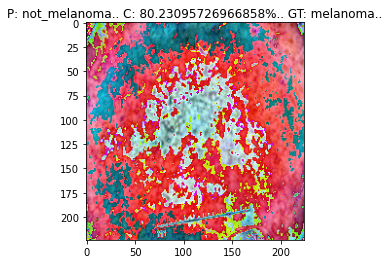

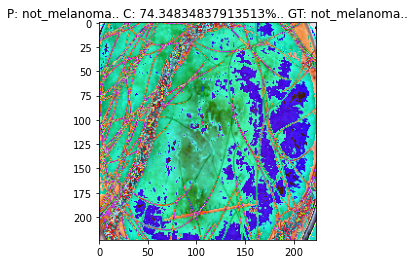

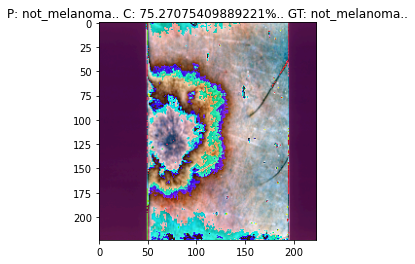

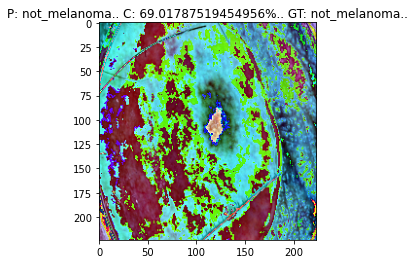

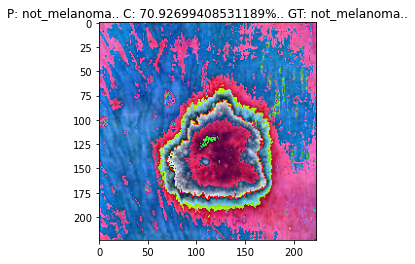

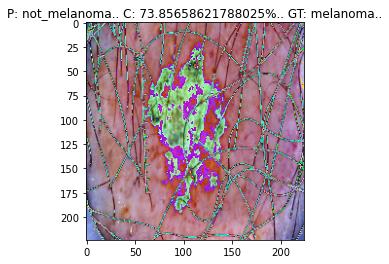

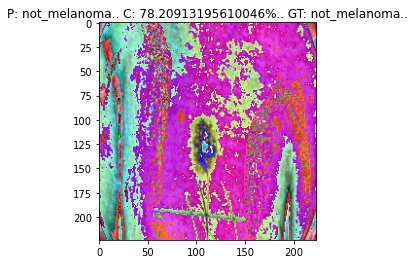

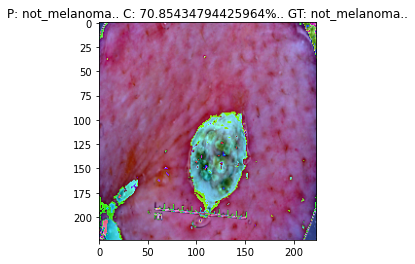

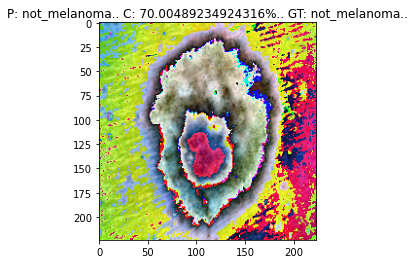

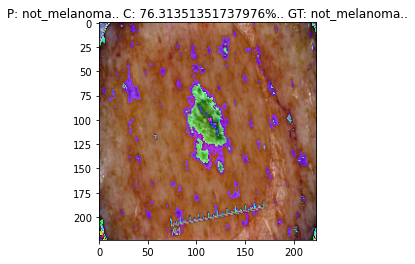

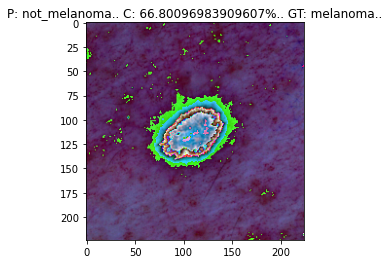

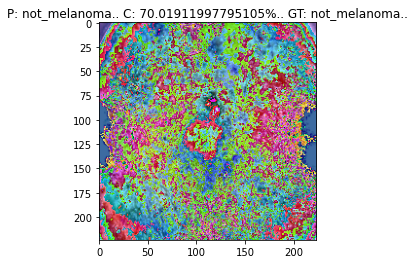

Total Correct: 483/600
Total Accuracy: 80.50%


In [ ]:
test_model()

In [ ]:
torch.save(model.state_dict(), 'resnet.pt')

In [ ]:
train_dataset = torch.load('model_data/train_dataset.pt')

## Autoencoder

In [ ]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(224 * 224, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 224 * 224),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}

# Instantiating the model and hyperparameters
model = DeepAutoencoder().to(device)
criterion = torch.nn.MSELoss()
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  
batch_size = len(train_loader)
  
# Training loop starts
for epoch in range(num_epochs):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch
        img = img.to(device)
        img = img.reshape(-1, 224*224)
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
        
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
    
    print(f'epoch: {epoch}, loss: {running_loss}')
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

NameError: name 'DeepAutoencoder' is not defined

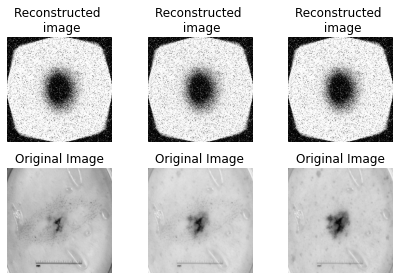

In [ ]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the first batch from the test 
# dataset
img, _ = next(iter(test_loader))

img = img.to(device)

# Reshaping into 1d vector
img = img.reshape(-1, 224 * 224)
  
# Generating output for the obtained
# batch
out = model(img)
  
# Storing information in dictionary
outputs['img'] = img
outputs['out'] = out
  
# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()
  
# Plotting first 10 images of the batch
for idx in range(3):
    plt.subplot(2, 3, counter)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting first 10 images
for idx in range(3):
    val = outputs['img'].detach().cpu().numpy()
    plt.subplot(2, 3, counter)
    plt.imshow(val[idx].reshape(224, 224), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()

## GAN
https://github.com/ttchengab/MnistGAN/blob/main/model.py

In [ ]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(224 * 224, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 224 * 224)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 224 * 224)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 224, 224)
        return nn.Tanh()(x)

In [ ]:
train_transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],
                                 std=[0.229])
])

test_transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],
                                 std=[0.229])
])

train_dataset = ImageFolder(data_train_path, transform = train_transform)
valid_dataset = ImageFolder(data_valid_path, transform = test_transform)
test_dataset = ImageFolder(data_test_path, transform = test_transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

In [ ]:
epochs = 1
lr = 1e-4
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))



"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        
#         print(real_outputs.shape, real_inputs.squeeze(1).shape)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        
#         print(outputs.shape, targets.shape)
        
        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

KeyboardInterrupt: 

## Logistic Regression

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(224 * 224 * 3, 1)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [ ]:
torch.cuda.empty_cache()

model = LogisticRegression().to(device)

LEARNING_RATE = 0.001
EPOCHS = 1
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 0.001)
criterion = nn.BCELoss()

min_loss = -1
train(model, EPOCHS, criterion, min_loss, optimizer, vectorize=True)

In [ ]:
model = LogisticRegression().to(device)
model

LogisticRegression(
  (linear): Linear(in_features=150528, out_features=2, bias=True)
)